In [26]:
#Importing the required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

In [2]:
#Reading in the dataset
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")
data = df
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
# Count the occurrences of 0s and 1s in the 'high_blood_pressure' column
blood_pressure_counts = df['high_blood_pressure'].value_counts()

# Display the counts
print(blood_pressure_counts)

0    194
1    105
Name: high_blood_pressure, dtype: int64


In [4]:
# Group the data by 'high_blood_pressure' and calculate the number of deaths in each group
deaths_by_blood_pressure = df.groupby('high_blood_pressure')['DEATH_EVENT'].sum()

# Displaying the result
print(deaths_by_blood_pressure)
# This is interesting as only 39 of the 96 people who died had high blood pressure

high_blood_pressure
0    57
1    39
Name: DEATH_EVENT, dtype: int64


### Splitting the Dataset

In [5]:
# Selecting the features (X) and target variable (y)
df1 = df.drop('time',axis=1)
X = df1.drop('DEATH_EVENT',axis=1)
y=df['DEATH_EVENT']

In [6]:
from sklearn.model_selection import train_test_split

#Splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=40)

# 30% of the data will be used for testing, and 70% for training.
#'random_state' parameter is used to ensure reproducibility of the split.

# Displaying the shape of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (209, 11)
X_test shape: (90, 11)
y_train shape: (209,)
y_test shape: (90,)


In [7]:
#Function which gives all the metrics of a model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def generate_model_report(y_actual, y_predicted):
    print("Accuracy = " , accuracy_score(y_actual, y_predicted))
    print("Precision = " ,precision_score(y_actual, y_predicted))
    print("Recall = " ,recall_score(y_actual, y_predicted))
    print("F1 Score = " ,f1_score(y_actual, y_predicted))


In [8]:
#Function for creating ROC curve
def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

### Scaling

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from statsmodels.stats.proportion import proportion_confint


num_att = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']
bin_att = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

class DataFrameSelector(BaseEstimator):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_att)),
    ('std_scaler', StandardScaler())
])

bin_pipeline = Pipeline([
    ('selector', DataFrameSelector(bin_att))
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("bin_pipeline", bin_pipeline)
])

X_train_ = full_pipeline.fit_transform(X_train)
X_test_ = full_pipeline.transform(X_test)

### SMOTE on the dataset

In [10]:
sm = SMOTE(random_state=42, sampling_strategy=1.0)
x_train_res, y_train_res = sm.fit_resample(X_train_, y_train)
x_train_res_nosc, y_train_res_nosc = sm.fit_resample(X_train, y_train)

### KNN

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid for tuning
param_grid = {
    'n_neighbors': range(1, 21),  # Test values from 1 to 20 neighbors
}

# Create the KNN model
knn_model = KNeighborsClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV to the training data (using X_train_)
grid_search.fit(X_train_, y_train)

best_n_neighbors = grid_search.best_params_['n_neighbors']
best_knn_model = grid_search.best_estimator_

print("Best number of neighbors:", best_n_neighbors)

# Train the best model on the full training dataset (not needed if using GridSearchCV)
best_knn_model.fit(X_train_, y_train)

# Make predictions on the test set using the best model (using X_test_)
y_pred_knn = best_knn_model.predict(X_test_)


Best number of neighbors: 11


In [12]:
print(accuracy_score(y_test,y_pred_knn))
pd.crosstab(y_test,y_pred_knn)

0.7555555555555555


col_0,0,1
DEATH_EVENT,,
0,57,4
1,18,11


In [13]:
generate_model_report(y_test, y_pred_knn)

Accuracy =  0.7555555555555555
Precision =  0.7333333333333333
Recall =  0.3793103448275862
F1 Score =  0.5


### KNN with SMOTE

In [14]:
best_knn_model.fit(x_train_res, y_train_res)
best_knn_model.score(X_test_,y_test)

0.7777777777777778

In [15]:
Y_Test_Pred_knn = best_knn_model.predict(X_test_)
generate_model_report(y_test, Y_Test_Pred_knn)

Accuracy =  0.7777777777777778
Precision =  0.6363636363636364
Recall =  0.7241379310344828
F1 Score =  0.6774193548387097


In [16]:
pd.crosstab(y_test,Y_Test_Pred_knn)

col_0,0,1
DEATH_EVENT,,
0,49,12
1,8,21


### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Define the parameter grid for tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],       # Regularization strength values to test
    'penalty': ['l1', 'l2'],                  # Penalty type ('l1' for L1 regularization, 'l2' for L2 regularization)
    'solver': ['liblinear'],                  # Solver for handling penalty ('liblinear' is suitable for small datasets)
    'max_iter': [100, 200, 500]               # Maximum number of iterations for convergence
}

# Create the logistic regression model
log_r = LogisticRegression(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(log_r, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the best model
best_C = grid_search.best_params_['C']
best_penalty = grid_search.best_params_['penalty']
best_max_iter = grid_search.best_params_['max_iter']
best_log_r_model = grid_search.best_estimator_

print("Best C value:", best_C)
print("Best penalty type:", best_penalty)
print("Best maximum iterations:", best_max_iter)

# Train the best model on the full training dataset (not needed if using GridSearchCV)
# best_log_r_model.fit(X_train, y_train)

# Make predictions on the test set using the best model
y_pred_log_r = best_log_r_model.predict(X_test)

# Create a confusion matrix
confusion_matrix = pd.crosstab(y_pred_log_r, y_test, rownames=['Predicted'], colnames=['Actual'])
print(confusion_matrix)


Best C value: 1
Best penalty type: l1
Best maximum iterations: 100
Actual      0   1
Predicted        
0          55  13
1           6  16


In [18]:
#Classification Metric of Logistic Regression model
generate_model_report(y_test, y_pred_log_r)

Accuracy =  0.7888888888888889
Precision =  0.7272727272727273
Recall =  0.5517241379310345
F1 Score =  0.6274509803921569


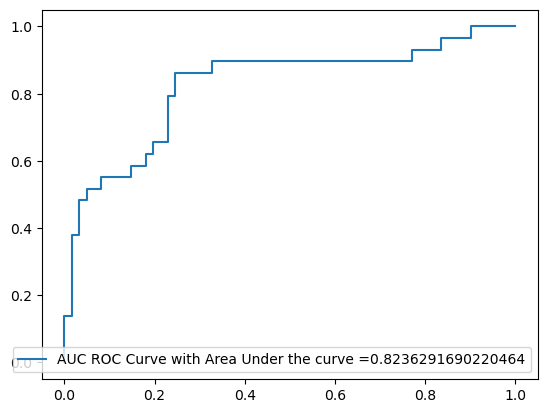

In [19]:
generate_auc_roc_curve(best_log_r_model, X_test)

### Logistic Regression with SMOTE

In [20]:
log_r_with_smote = best_log_r_model.fit(x_train_res_nosc, y_train_res_nosc)

y_pred_with_smote = log_r_with_smote.predict(X_test)

In [21]:
#Classification Metric of Logistic Regression model
generate_model_report(y_test, y_pred_with_smote)

Accuracy =  0.7222222222222222
Precision =  0.5555555555555556
Recall =  0.6896551724137931
F1 Score =  0.6153846153846154


### Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Step 1: Hyperparameter tuning for Decision Tree without SMOTE
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8]
}

dt_model_no_smote = DecisionTreeClassifier(random_state=42)
grid_search_dt_no_smote = GridSearchCV(dt_model_no_smote, param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt_no_smote.fit(X_train, y_train)

best_dt_model_no_smote = grid_search_dt_no_smote.best_estimator_

# Step 2: Hyperparameter tuning for Decision Tree with SMOTE

dt_model_with_smote = DecisionTreeClassifier(random_state=42)
grid_search_dt_with_smote = GridSearchCV(dt_model_with_smote, param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt_with_smote.fit(x_train_res_nosc, y_train_res_nosc)

best_dt_model_with_smote = grid_search_dt_with_smote.best_estimator_

# Step 3: Evaluate both models on the test set
y_pred_no_smote = best_dt_model_no_smote.predict(X_test)
y_pred_with_smote = best_dt_model_with_smote.predict(X_test)

# Calculate and print performance metrics for the model without SMOTE
print("Decision Tree without SMOTE:")
print("Accuracy:", accuracy_score(y_test, y_pred_no_smote))
print("Precision:", precision_score(y_test, y_pred_no_smote))
print("Recall:", recall_score(y_test, y_pred_no_smote))
print("F1 Score:", f1_score(y_test, y_pred_no_smote))

# Calculate and print performance metrics for the model with SMOTE
print("\nDecision Tree with SMOTE:")
print("Accuracy:", accuracy_score(y_test, y_pred_with_smote))
print("Precision:", precision_score(y_test, y_pred_with_smote))
print("Recall:", recall_score(y_test, y_pred_with_smote))
print("F1 Score:", f1_score(y_test, y_pred_with_smote))


Decision Tree without SMOTE:
Accuracy: 0.7666666666666667
Precision: 0.6538461538461539
Recall: 0.5862068965517241
F1 Score: 0.6181818181818182

Decision Tree with SMOTE:
Accuracy: 0.7
Precision: 0.5238095238095238
Recall: 0.7586206896551724
F1 Score: 0.6197183098591549


### Random Forest

In [33]:
from sklearn.feature_selection import SelectFromModel

# Step 1: Hyperparameter tuning for Random Forest without SMOTE
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,4,6],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model_no_smote = RandomForestClassifier(random_state=42)
grid_search_rf_no_smote = GridSearchCV(rf_model_no_smote, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf_no_smote.fit(X_train, y_train)

best_rf_model_no_smote = grid_search_rf_no_smote.best_estimator_

# Step 2: Hyperparameter tuning for Random Forest with SMOTE and feature selection
rf_model_with_smote = RandomForestClassifier(random_state=42)
grid_search_rf_with_smote = GridSearchCV(rf_model_with_smote, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf_with_smote.fit(x_train_res_nosc, y_train_res_nosc)

best_rf_model_with_smote = grid_search_rf_with_smote.best_estimator_

# Step 3: Feature selection for Random Forest with SMOTE
sfm = SelectFromModel(best_rf_model_with_smote, threshold='mean')
sfm.fit(x_train_res_nosc, y_train_res_nosc)
x_train_selected = sfm.transform(x_train_res_nosc)
x_test_selected = sfm.transform(X_test)

# Step 4: Train Random Forest with selected features and evaluate on test set
best_rf_model_with_smote.fit(x_train_selected, y_train_res_nosc)
y_pred_with_smote = best_rf_model_with_smote.predict(x_test_selected)

# Calculate and print performance metrics for the model without SMOTE
print("Random Forest without SMOTE:")
print("Accuracy:", accuracy_score(y_test, best_rf_model_no_smote.predict(X_test)))
print("Precision:", precision_score(y_test, best_rf_model_no_smote.predict(X_test)))
print("Recall:", recall_score(y_test, best_rf_model_no_smote.predict(X_test)))
print("F1 Score:", f1_score(y_test, best_rf_model_no_smote.predict(X_test)))

# Calculate and print performance metrics for the model with SMOTE and feature selection
print("\nRandom Forest with SMOTE and feature selection:")
print("Accuracy:", accuracy_score(y_test, y_pred_with_smote))
print("Precision:", precision_score(y_test, y_pred_with_smote))
print("Recall:", recall_score(y_test, y_pred_with_smote))
print("F1 Score:", f1_score(y_test, y_pred_with_smote))


Random Forest without SMOTE:
Accuracy: 0.7444444444444445
Precision: 0.6666666666666666
Recall: 0.41379310344827586
F1 Score: 0.5106382978723404

Random Forest with SMOTE and feature selection:
Accuracy: 0.7555555555555555
Precision: 0.5897435897435898
Recall: 0.7931034482758621
F1 Score: 0.676470588235294


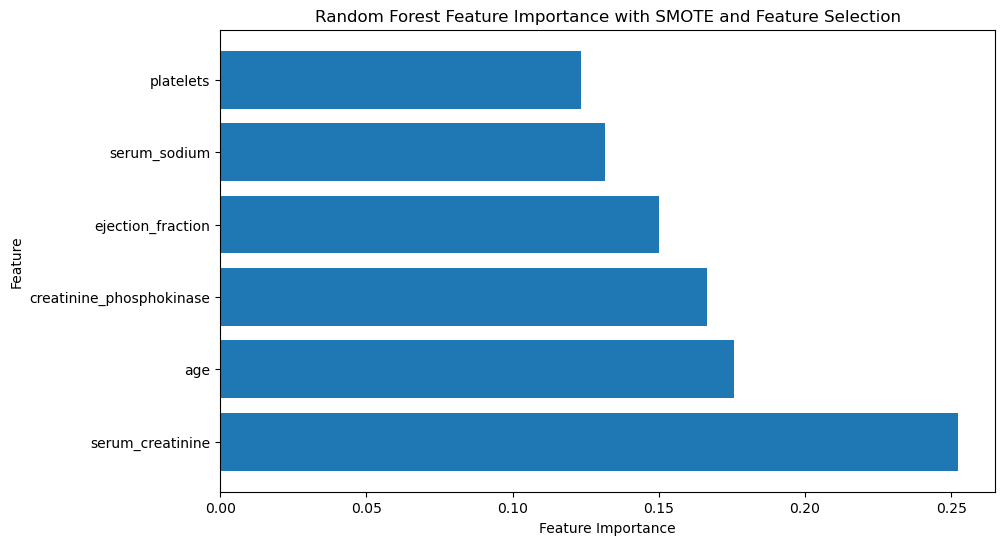

In [24]:
import matplotlib.pyplot as plt

# Get feature importance from the best Random Forest model with SMOTE
feature_importance = best_rf_model_with_smote.feature_importances_

# Get the corresponding feature names
selected_feature_names = X_train.columns[sfm.get_support()]

# Create a DataFrame to store the feature importance values with their names
feature_importance_df = pd.DataFrame({'Feature': selected_feature_names, 'Importance': feature_importance})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance with SMOTE and Feature Selection')
plt.show()


### Naive Bayes

In [29]:
# Step 2: Create and train the Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Step 3: Make predictions on the test set
y_predn = nb_model.predict(X_test)

# Calculate and print performance metrics for the model with SMOTE
print("Naive Bayes without SMOTE:")
print("Accuracy:", accuracy_score(y_test, y_predn))
print("Precision:", precision_score(y_test, y_predn))
print("Recall:", recall_score(y_test, y_predn))
print("F1 Score:", f1_score(y_test, y_predn))

Naive Bayes without SMOTE:
Accuracy: 0.6444444444444445
Precision: 0.3333333333333333
Recall: 0.10344827586206896
F1 Score: 0.15789473684210528


In [28]:
nb_model.fit(x_train_res_nosc, y_train_res_nosc)

# Step 3: Make predictions on the test set
y_pred = nb_model.predict(X_test)

# Calculate and print performance metrics for the model with SMOTE
print("Naive Bayes with SMOTE:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Naive Bayes with SMOTE:
Accuracy: 0.6888888888888889
Precision: 0.52
Recall: 0.4482758620689655
F1 Score: 0.48148148148148145
